# **Initialization**

In [20]:
from matplotlib import pyplot as plot
from typing import Literal, get_args
import numpy, pandas, warnings

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

pandas.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

random_state = 42
numpy.random.seed(random_state) 

# Data Extraction

label_key = 'Life ladder'

training_data = pandas.read_csv('data/train.csv')
testing_data = pandas.read_csv('data/test.csv')

features_training = training_data.drop(label_key, axis=1)
label_training = training_data[label_key]

features_testing = testing_data.drop(label_key, axis=1)
label_testing = testing_data[label_key]

preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())               
])

# Hyperparameters

tolerance = 1e-7
max_iterations = 10000
alphas = [0.001, 0.005, 0.1]
eta0s = [0.001, 0.005, 0.01]
penalties = get_args(Literal['l2', 'l1', 'elasticnet'])
learning_rates = ['constant', 'optimal', 'invscaling', 'adaptive']

cross_validator  = KFold(n_splits=4, shuffle=True, random_state=random_state)

# **Cross Validation**

## Closed-Form Solution

In [21]:
rmse_values = -cross_val_score(
                Pipeline(
                    steps = preprocessing_pipeline.steps + [('model', LinearRegression())]
                ), 
                features_training, 
                label_training, 
                cv=cross_validator, 
                scoring='neg_root_mean_squared_error'
            )

print(f'RMSE Values: {numpy.round(rmse_values, 4)}')
print(f'Mean RMSE: {rmse_values.mean():.4f}')
print(f'Standard Deviation of RMSE: {rmse_values.std():.4f}')

RMSE Values: [0.6015 0.5274 0.5336 0.5318]
Mean RMSE: 0.5486
Standard Deviation of RMSE: 0.0307


## SGD (Stochastic Gradient Descent) Regressor

In [22]:
results = []

for penalty in penalties:
    for alpha in alphas:
        for eta0 in eta0s:
            sgd_pipeline = Pipeline(
                steps = preprocessing_pipeline.steps + [
                    (
                        'model', SGDRegressor
                        (
                            penalty = penalty,
                            alpha=alpha,
                            eta0=eta0,
                            learning_rate='constant',
                            shuffle=True,
                            max_iter=max_iterations,  
                            tol=tolerance, 
                            random_state=random_state
                        )
                    )
                ]
            )
            rmse_values = -cross_val_score(sgd_pipeline, features_training, label_training, cv=cross_validator , scoring='neg_root_mean_squared_error')
            results.append({
                'Penalty': penalty,
                'Alpha': alpha,
                'Learning Rate': eta0,
                'Mean RMSE': rmse_values.mean(),
                'Standard Deviation of RMSE':  rmse_values.std()
            })

results = pandas.DataFrame(results).sort_values('Mean RMSE').reset_index(drop=True)
optimal_configuration = results.iloc[0]
display(results)

,Penalty,Alpha,Learning Rate,Mean RMSE,Standard Deviation of RMSE
0,elasticnet,0.0050,0.0010,0.5486,0.0302
1,l2,0.0050,0.0010,0.5486,0.0301
2,l1,0.0010,0.0010,0.5486,0.0302
3,elasticnet,0.0010,0.0010,0.5486,0.0302
4,l1,0.0050,0.0010,0.5487,0.0302
5,l2,0.0010,0.0010,0.5490,0.0308
6,elasticnet,0.0050,0.0050,0.5494,0.0329
7,l1,0.0010,0.0050,0.5494,0.0329
8,l1,0.0050,0.0050,0.5495,0.0328
9,l2,0.1000,0.0010,0.5497,0.0289


# **Graphical Representation**

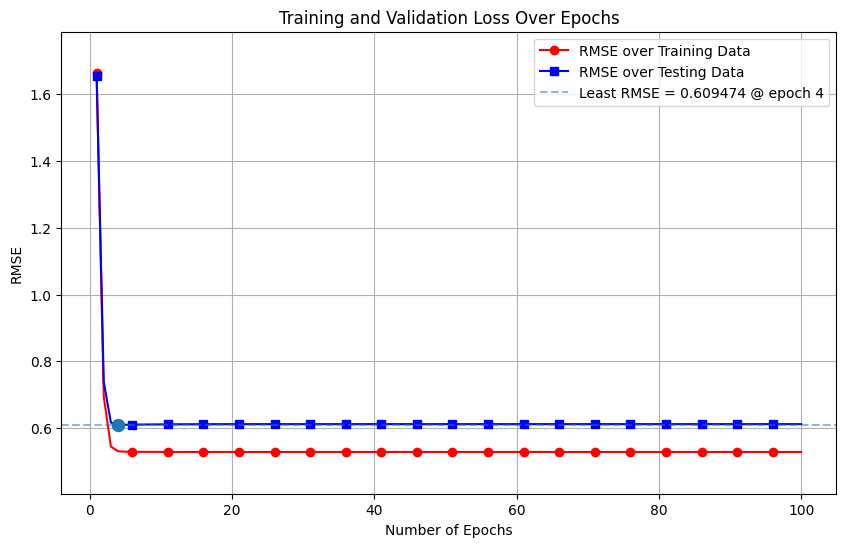

In [23]:
X_training, X_testing, y_training, y_testing = train_test_split(
    features_training, label_training, test_size=0.2, random_state=random_state
)

X_training = preprocessing_pipeline.fit_transform(X_training)
X_testing   = preprocessing_pipeline.transform(X_testing)

model = SGDRegressor(
    penalty=optimal_configuration['Penalty'],
    alpha=optimal_configuration['Alpha'],
    eta0=optimal_configuration['Learning Rate'],
    learning_rate='constant',
    shuffle=True,
    tol=None,
    max_iter=1,          
    warm_start=True,     
    random_state=random_state
)

errors_training, errors_testing = [], []
least_rmse = float('inf') 
minimum_epochs = None
epochs_count = 100

for epoch in range(1, epochs_count + 1):

    model.fit(X_training, y_training)      

    predictions_training = model.predict(X_training)
    predictions_testing = model.predict(X_testing)

    error_training = root_mean_squared_error(y_training, predictions_training)
    error_testing = root_mean_squared_error(y_testing, predictions_testing)

    errors_training.append(error_training)
    errors_testing.append(error_testing)

    if error_testing < least_rmse:
        least_rmse, minimum_epochs = error_testing, epoch


plot.figure(figsize=(10, 6))

x_axis = range(1, epochs_count + 1)
plot.plot(x_axis, errors_training, 'r-', marker='o', markevery=5, label = 'RMSE over Training Data')
plot.plot(x_axis, errors_testing,   'b-', marker='s', markevery=5, label = 'RMSE over Testing Data')

buffer = 0.125
plot.ylim(min(errors_training + errors_testing) - buffer, max(errors_training + errors_testing) + buffer)

plot.axhline(least_rmse, ls='--', alpha=0.5, label=f'Least RMSE = {least_rmse:4f} @ epoch {minimum_epochs}')
plot.scatter([minimum_epochs], [least_rmse], s=75, zorder=2)

plot.xlabel('Number of Epochs')
plot.ylabel('RMSE')

plot.title('Training and Validation Loss Over Epochs')
plot.grid(True)
plot.legend()
plot.show()

# **Test Data Evaluation**

In [24]:
closed_form_pipeline = Pipeline(
    steps=preprocessing_pipeline.steps + [
        ('model', LinearRegression())
    ]
)

closed_form_pipeline.fit(features_training, label_training)
print(f'RMSE with Closed Form: {root_mean_squared_error(label_testing, closed_form_pipeline.predict(features_testing))}')

sgd_pipeline = Pipeline(
    steps=preprocessing_pipeline.steps + [
        ('model', SGDRegressor(
            penalty=optimal_configuration['Penalty'],
            alpha=optimal_configuration['Alpha'],
            eta0=optimal_configuration['Learning Rate'],
            learning_rate='constant',        
            random_state=random_state,
            max_iter=max_iterations,
            tol=tolerance,
            shuffle=True
        ))
    ]
)

sgd_pipeline.fit(features_training, label_training)

print(f'RMSE with SGD: {root_mean_squared_error(label_testing, sgd_pipeline.predict(features_testing))}')

RMSE with Closed Form: 0.553040402286619
RMSE with SGD: 0.5526040278918433
